<a href="https://colab.research.google.com/github/itsdivya1309/Machine-Learning/blob/main/LLMs/Text%20Classification/Text_Classification_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install datasets
! pip install contractions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset

import re
import contractions

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn import naive_bayes, linear_model, svm, metrics, ensemble
import xgboost

In [3]:
# Pre-trained word embeddings for Neural Networks

!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip  # Download GloVe embeddings
!unzip glove.6B.zip  # Unzip the file

--2025-02-02 05:36:07--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
Resolving huggingface.co (huggingface.co)... 3.165.160.11, 3.165.160.12, 3.165.160.59, ...
Connecting to huggingface.co (huggingface.co)|3.165.160.11|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/stanfordnlp/glove/6471382cdd837544bf3ac72497a38715e845897d265b2b424b4761832009c837?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27glove.6B.zip%3B+filename%3D%22glove.6B.zip%22%3B&response-content-type=application%2Fzip&Expires=1738478167&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczODQ3ODE2N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9zdGFuZm9yZG5scC9nbG92ZS82NDcxMzgyY2RkODM3NTQ0YmYzYWM3MjQ5N2EzODcxNWU4NDU4OTdkMjY1YjJiNDI0YjQ3NjE4MzIwMDljODM3P3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiZyZXNwb25zZS1jb250ZW50LXR5cGU9KiJ9XX0_&Signature=Qc%7Eei9jpGA09gHv6MG3SVGqiQ2rkTXEj-6F93qmkzrHg8VU8q0Co

In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
# Load Rotten Tomatoes Moview Review dataset
data = load_dataset('rotten_tomatoes')
data

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [6]:
data['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 8530
})

In [7]:
train = data['train'].to_pandas()
train.head()

,text,label
0,"the rock is destined to be the 21st century's new "" conan "" and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .",1
1,"the gorgeously elaborate continuation of "" the lord of the rings "" trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .",1
2,effective but too-tepid biopic,1
3,"if you sometimes like to go to the movies to have fun , wasabi is a good place to start .",1
4,"emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .",1


In [8]:
valid = data['validation'].to_pandas()
test = data['test'].to_pandas()

In [9]:
print('Train data shape: ', train.shape)
print('Validation data shape: ', valid.shape)
print('Test data shape: ', test.shape)

Train data shape:  (8530, 2)
Validation data shape:  (1066, 2)
Test data shape:  (1066, 2)


In [10]:
train = train.drop_duplicates()
valid = valid.drop_duplicates()
test = test.drop_duplicates()
print(train.isnull().sum())
print(valid.isnull().sum())
print(test.isnull().sum())

text     0
label    0
dtype: int64
text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


In [11]:
train['label'].value_counts()

,count
label,
1,4265
0,4265


# Binary Classification on Textual Data

**Target labels**:

1: positive review

0: negative review

The data does not contain any missing values or duplicated values. And luckily, there is no class imbalance.

## Text Preprocessing

In [12]:
def text_processor(df):
    df['text'] = df['text'].str.lower()
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
    df['text'] = df['text'].apply(lambda x: contractions.fix(x))
    return df

In [13]:
train = text_processor(train)
valid = text_processor(valid)
test = text_processor(test)

In [14]:
train.head()

,text,label
0,the rock is destined to be the st centurys new conan and that hes going to make a splash even greater than arnold schwarzenegger jeanclaud van damme or steven segal,1
1,the gorgeously elaborate continuation of the lord of the rings trilogy is so huge that a column of words cannot adequately describe cowriterdirector peter jacksons expanded vision of j are are tolkiens middleearth,1
2,effective but tootepid biopic,1
3,if you sometimes like to go to the movies to have fun wasabi is a good place to start,1
4,emerges as something rare an issue movie that is so honest and keenly observed that it does not feel like one,1


## Feature Engineering

### 1. Count Vectors as Features

In [15]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(train['text'])

train_count = count_vect.transform(train['text'])
valid_count = count_vect.transform(valid['text'])

In [16]:
train_count.shape

(8530, 17930)

In [17]:
train.shape

(8530, 2)

### 2. TF-IDF Vectors

In [18]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(train['text'])
train_tfidf =  tfidf_vect.transform(train['text'])
valid_tfidf =  tfidf_vect.transform(valid['text'])

# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(train['text'])
train_tfidf_ngram =  tfidf_vect_ngram.transform(train['text'])
valid_tfidf_ngram =  tfidf_vect_ngram.transform(valid['text'])

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(train['text'])
train_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train['text'])
valid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid['text'])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:547: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [19]:
train_tfidf.shape

(8530, 5000)

### 3. Pre-trained Word Embeddings

In [20]:
from tensorflow.keras.preprocessing import text, sequence

In [21]:
embedding_index = {}
# Load the pre-trained GloVe embeddings into a dictionary
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding_vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = embedding_vector

# Create a tokenizer
token = text.Tokenizer()
token.fit_on_texts(train['text'])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors
train_seq = sequence.pad_sequences(token.texts_to_sequences(train['text']), maxlen=100)
valid_seq = sequence.pad_sequences(token.texts_to_sequences(valid['text']), maxlen=100)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [22]:
embedding_matrix.shape

(17943, 100)

## Model Building

1. Naive Bayes Classifier
2. Linear Classifier
3. Support Vector Machine
4. Bagging Models
5. Boosting Models
6. Shallow Neural Networks
7. Deep Neural Networks
    * Convolutional Neural Network (CNN)
    * Long Short Term Modelr (LSTM)
    * Gated Recurrent Unit (GRU)
    * Bidirectional RNN

In [23]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, valid_label, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)

    if is_neural_net:
        predictions = predictions.argmax(axis=-1)

    return metrics.accuracy_score(predictions, valid_label)

In [24]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), train_count, train['label'], valid_count, valid['label'])
print("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), train_tfidf, train['label'], valid_tfidf, valid['label'])
print("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), train_tfidf_ngram, train['label'], valid_tfidf_ngram, valid['label'])
print("NB, N-Gram Vectors: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), train_tfidf_ngram_chars, train['label'], valid_tfidf_ngram_chars, valid['label'])
print("NB, CharLevel Vectors: ", accuracy)


NB, Count Vectors:  0.7729831144465291
NB, WordLevel TF-IDF:  0.7570356472795498
NB, N-Gram Vectors:  0.6594746716697936
NB, CharLevel Vectors:  0.723264540337711


In [25]:
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), train_count, train['label'], valid_count, valid['label'])
print("LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), train_tfidf, train['label'], valid_tfidf, valid['label'])
print("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), train_tfidf_ngram, train['label'], valid_tfidf_ngram, valid['label'])
print("LR, N-Gram Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), train_tfidf_ngram_chars, train['label'], valid_tfidf_ngram_chars, valid['label'])
print("LR, CharLevel Vectors: ", accuracy)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, Count Vectors:  0.7504690431519699
LR, WordLevel TF-IDF:  0.725140712945591
LR, N-Gram Vectors:  0.6622889305816135
LR, CharLevel Vectors:  0.7317073170731707


In [26]:
# SVM Classifier on Count Vectors
accuracy = train_model(svm.SVC(), train_count, train['label'], valid_count, valid['label'])
print("SVM, Count Vectors: ", accuracy)

# SVM on Word Level TF IDF Vectors
accuracy = train_model(svm.SVC(), train_tfidf, train['label'], valid_tfidf, valid['label'])
print("SVM, WordLevel TF-IDF: ", accuracy)

# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(), train_tfidf_ngram, train['label'], valid_tfidf_ngram, valid['label'])
print("SVM, N-Gram Vectors: ", accuracy)

# SVM on Character Level TF IDF Vectors
accuracy = train_model(svm.SVC(), train_tfidf_ngram_chars, train['label'], valid_tfidf_ngram_chars, valid['label'])
print("SVM, CharLevel Vectors: ", accuracy)

SVM, Count Vectors:  0.7213883677298312
SVM, WordLevel TF-IDF:  0.7392120075046904
SVM, N-Gram Vectors:  0.6613508442776735
SVM, CharLevel Vectors:  0.7448405253283302


In [27]:
# RF Classifier on Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), train_count, train['label'], valid_count, valid['label'])
print("RF, Count Vectors: ", accuracy)

# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), train_tfidf, train['label'], valid_tfidf, valid['label'])
print("RF, WordLevel TF-IDF: ", accuracy)

# RF on Ngram Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), train_tfidf_ngram, train['label'], valid_tfidf_ngram, valid['label'])
print("RF, N-Gram Vectors: ", accuracy)

# RF on Character Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), train_tfidf_ngram_chars, train['label'], valid_tfidf_ngram_chars, valid['label'])
print("RF, CharLevel Vectors: ", accuracy)

RF, Count Vectors:  0.6782363977485929
RF, WordLevel TF-IDF:  0.6791744840525328
RF, N-Gram Vectors:  0.6425891181988743
RF, CharLevel Vectors:  0.6782363977485929


In [28]:
# XGBoost Classifier on Count Vectors
accuracy = train_model(xgboost.XGBClassifier(), train_count, train['label'], valid_count, valid['label'])
print("XGBoost, Count Vectors: ", accuracy)

# XGBoost on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), train_tfidf, train['label'], valid_tfidf, valid['label'])
print("XGBoost, WordLevel TF-IDF: ", accuracy)

# XGBoost on Ngram Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), train_tfidf_ngram, train['label'], valid_tfidf_ngram, valid['label'])
print("XGBoost, N-Gram Vectors: ", accuracy)

# XGBoost on Character Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), train_tfidf_ngram_chars, train['label'], valid_tfidf_ngram_chars, valid['label'])
print("XGBoost, CharLevel Vectors: ", accuracy)

XGBoost, Count Vectors:  0.6923076923076923
XGBoost, WordLevel TF-IDF:  0.6772983114446529
XGBoost, N-Gram Vectors:  0.6210131332082551
XGBoost, CharLevel Vectors:  0.6782363977485929


In [29]:
from keras.callbacks import EarlyStopping
from keras import optimizers
from tensorflow.keras import layers, models

In [30]:
def create_rnn_lstm():
    # Add an Input Layer
    input_layer = layers.Input((100, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.LSTM(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(25, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(25, activation="relu")(output_layer1)
    output_layer2 = layers.Dropout(0.25)(output_layer2)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer2)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [31]:
# Create the model
model = create_rnn_lstm()

# Set up EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # What to monitor (use 'val_accuracy' to monitor accuracy)
    patience=3,  # Number of epochs to wait for improvement
    restore_best_weights=True,  # Restore weights from the best epoch
    verbose=1  # Display the progress
)

# Train the model with specified epochs and EarlyStopping
history = model.fit(
    train_seq,  # Training data (padded sequences)
    train['label'],  # Training labels
    validation_data=(valid_seq, valid['label']),  # Validation data and labels
    epochs=30,  # Number of epochs
    batch_size=64,  # Batch size
    callbacks=[early_stopping]  # Pass the early stopping callback
)

Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5717 - loss: 0.6746 - val_accuracy: 0.6961 - val_loss: 0.5962
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6696 - loss: 0.6110 - val_accuracy: 0.7214 - val_loss: 0.5557
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7058 - loss: 0.5752 - val_accuracy: 0.7392 - val_loss: 0.5248
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7173 - loss: 0.5460 - val_accuracy: 0.7477 - val_loss: 0.5131
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7281 - loss: 0.5378 - val_accuracy: 0.7430 - val_loss: 0.5041
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7479 - loss: 0.5201 - val_accuracy: 0.7364 - val_loss: 0.5206
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7509 - loss: 0.5024 - val_accuracy: 0.7533 - val_loss: 0.4929
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7590 - loss: 0.4960 - val_accu

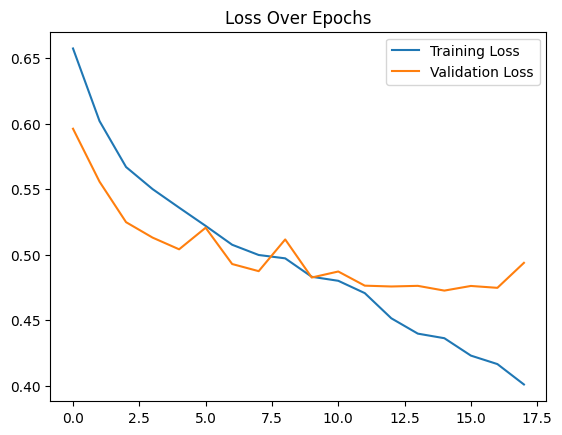

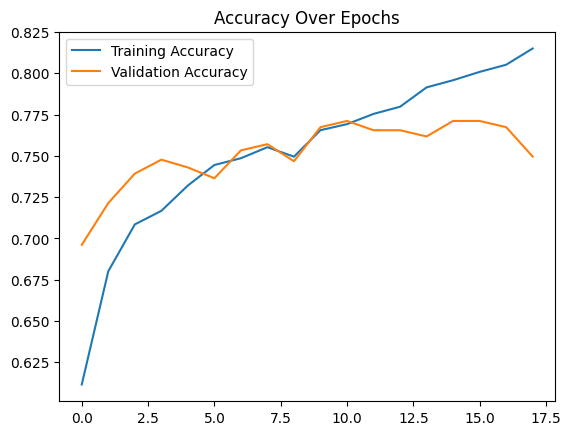

In [32]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

# Plot training and validation accuracy (if applicable)
plt.plot(history.history.get('accuracy', []), label='Training Accuracy')
plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()


In [33]:
def create_rnn_gru():
    # Add an Input Layer
    input_layer = layers.Input((100, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the GRU Layer
    lstm_layer = layers.GRU(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [34]:
# Create the model
model = create_rnn_gru()

# Set up EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # What to monitor (use 'val_accuracy' to monitor accuracy)
    patience=3,  # Number of epochs to wait for improvement
    restore_best_weights=True,  # Restore weights from the best epoch
    verbose=1  # Display the progress
)

# Train the model with specified epochs and EarlyStopping
history = model.fit(
    train_seq,  # Training data (padded sequences)
    train['label'],  # Training labels
    validation_data=(valid_seq, valid['label']),  # Validation data and labels
    epochs=30,  # Number of epochs
    batch_size=64,  # Batch size
    callbacks=[early_stopping]  # Pass the early stopping callback
)

Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5550 - loss: 0.6795 - val_accuracy: 0.6876 - val_loss: 0.5965
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6786 - loss: 0.5909 - val_accuracy: 0.7420 - val_loss: 0.5418
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7107 - loss: 0.5577 - val_accuracy: 0.7514 - val_loss: 0.5155
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7387 - loss: 0.5241 - val_accuracy: 0.7355 - val_loss: 0.5168
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7458 - loss: 0.5092 - val_accuracy: 0.7542 - val_loss: 0.4960
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7405 - loss: 0.5123 - val_accuracy: 0.7467 - val_loss: 0.4903
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7487 - loss: 0.5031 - val_accuracy: 0.7561 - val_loss: 0.4881
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7673 - loss: 0.4682 - val_accura

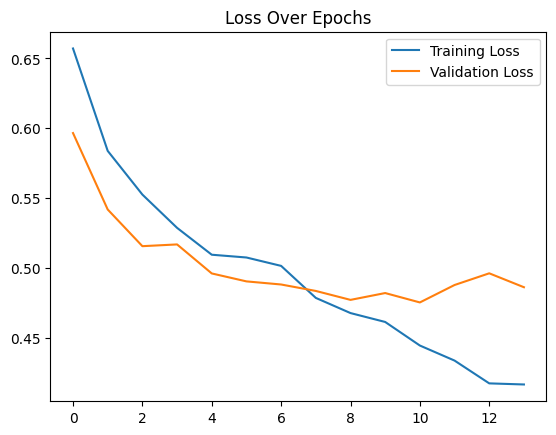

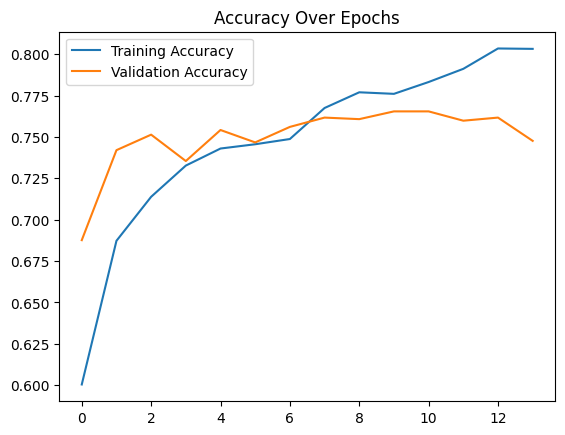

In [35]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

# Plot training and validation accuracy (if applicable)
plt.plot(history.history.get('accuracy', []), label='Training Accuracy')
plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

In [36]:
def create_bidirectional_rnn():
    # Add an Input Layer
    input_layer = layers.Input((100, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.Bidirectional(layers.GRU(100))(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [37]:
# Create the model
model = create_bidirectional_rnn()

# Set up EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # What to monitor (use 'val_accuracy' to monitor accuracy)
    patience=3,  # Number of epochs to wait for improvement
    restore_best_weights=True,  # Restore weights from the best epoch
    verbose=1  # Display the progress
)

# Train the model with specified epochs and EarlyStopping
history = model.fit(
    train_seq,  # Training data (padded sequences)
    train['label'],  # Training labels
    validation_data=(valid_seq, valid['label']),  # Validation data and labels
    epochs=30,  # Number of epochs
    batch_size=64,  # Batch size
    callbacks=[early_stopping]  # Pass the early stopping callback
)

Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5546 - loss: 0.6810 - val_accuracy: 0.6257 - val_loss: 0.6285
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6921 - loss: 0.5887 - val_accuracy: 0.7233 - val_loss: 0.5373
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7139 - loss: 0.5524 - val_accuracy: 0.7467 - val_loss: 0.5158
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7394 - loss: 0.5333 - val_accuracy: 0.7402 - val_loss: 0.5102
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7441 - loss: 0.5129 - val_accuracy: 0.7448 - val_loss: 0.5089
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7465 - loss: 0.5027 - val_accuracy: 0.7383 - val_loss: 0.5054
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7582 - loss: 0.4922 - val_accuracy: 0.7645 - val_loss: 0.4913
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7715 - loss: 0.4713 - val_accu

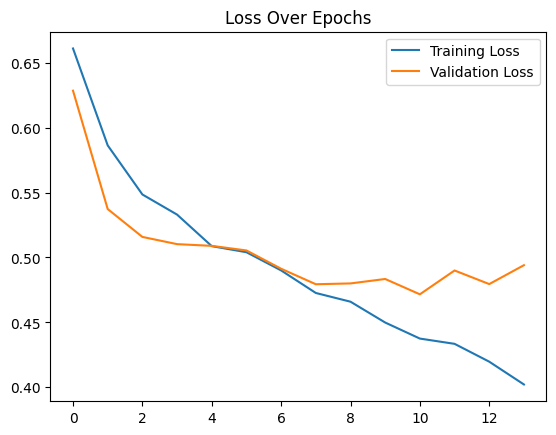

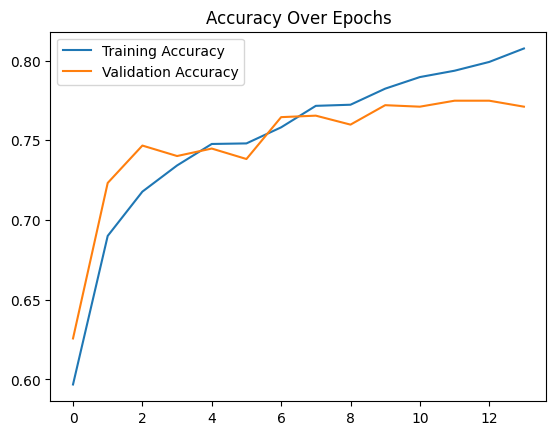

In [38]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

# Plot training and validation accuracy (if applicable)
plt.plot(history.history.get('accuracy', []), label='Training Accuracy')
plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()